# Quantify transports between Greenland and Iceland by source and destination

- Lagrangian particle tracking in VIKING20X model

- Pilot test case for June 2016

- Particles tracked backwards for 2 years (for sources) and forward for 6 months (for destinations)

- Advection only

- Transport calculations based on the idea of particle track representing a streamtube with constant along-tube transport everywhere

So, here we
- load lagrangian trajectory data that has been written by OceanParcels from particle tracking in Viking20x model (currently using monthly mean fields for speed)
    - particles tracked from a section across IFR
    - random release points along section
    - tracked forward for 6 months to id destinations
    - tracked backwards for 2 years to id sources
- plot sections
- plot trajectories
- subset trajectories based on source and destination
- estimate transports

Transports associated with different pathways are estimated by assuming that each particle crossing IFR has an associated volume transport, which it maintains throughout its life, given by the 
                velocity across the section * total cross-sectional area / number of particles
So like a streamtube...    

## To do

- calculate section area properly 
- explore sensitivity to particle numbers and random seed (i.e. do I have enough particles)
- calculate true transport across section in model
- not selecting ocean particles properly near bed - partial cells
- fix time units on track plots

## Technical preamble

In [1]:
%matplotlib inline

import matplotlib.colors as colors
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import xarray as xr
from datetime import datetime, timedelta
import seaborn as sns
from matplotlib.colors import ListedColormap
import cmocean as co

sns.set_palette("Paired")

## Parameters

In [2]:
# release time

trelease = np.datetime64('2014-12-16T12:00')

# Project path
project_path = Path.cwd() / '..' / '..' 
project_path = project_path.resolve()

# project_path = Path("C:/Users/sa05af/OneDrive - SAMS/Projects/parcels_quantitative_202004/")

# Parcels track data file
path_data_tracks = Path('data/processed/tracks/GreenlandIceland/') 
filename = 'tracks_parcels_GI_forwards_201412.nc'
filenameb = 'tracks_parcels_GI_backwards_201412.nc'

# model mask file
data_path = Path("data/external/iAtlantic/")
experiment_name = "VIKING20X.L46-KKG36107B"
mesh_mask_file = project_path / data_path / "mask" / experiment_name / "1_mesh_mask.nc"

#velocity conversions on GI section (67.3N)

lat2metres = 60.0*1852.0
lon2metres = 60.0*1852.0*np.cos(np.radians(67.3))

sealandratio = 2420.0/10000.0
sectionAreaEW = 5.73 * 1500.0 * sealandratio * lon2metres  # very approx. mean depth x length between slopes.
sectionAreaNS = 2.94 * 1500.0 * sealandratio * lat2metres

nParticles = 2000.0

## Some helper and plotting functions

In [3]:
def plot_release():
    plt.figure(figsize = (12,5))

    plt.scatter(
        ds.isel(obs=0).lon.data.flatten(),
        ds.isel(obs=0).z.data.flatten(),
        20,
        ds.isel(obs=0).vvel.data.flatten()*lon2metres
         , vmin = -.2, vmax = .2
        ,cmap= co.cm.balance
    #    ,alpha=0.3
    )

    plt.ylim(1500,0)

    plt.colorbar(label = "vvel [m/s]")
    plt.show()
    return


In [4]:
def plot_tracks(x,y,z,title):
    plt.figure(figsize = (15,9))

    # plot tracks as scatter plots

    plt.scatter(
        x
        ,y
        ,3
        ,z
        ,vmin = tvmin, vmax = tvmax
        ,cmap = co.cm.delta
    #    ,alpha=0.3
    )
    plt.colorbar(label = "time [stupid units. range 4 years, all cross IFR at 2 years]");

    # plot depth contours and land boundary from model bathymetry
    depth.isel(y=slice(1700, 2499), x=slice(1000, 2404)).plot.contour(
        x="nav_lon", y="nav_lat", colors = 'grey', levels = [200,800,1500,2000,2500,3500]
    );
    depth.isel(y=slice(1700, 2499), x=slice(1000, 2404)).plot.contour(
        x="nav_lon", y="nav_lat", colors = 'k', levels = [1]
    );
    # plt.savefig('upstream.png')
    plt.ylim(47.5,70)
    plt.xlim(-50,10)
    plt.title(title)
    plt.show()
    return

In [5]:
def plot_section():
    plt.figure(figsize = (12,6))

    plt.scatter(
        ds.isel(obs=0).lon.data.flatten(),
        ds.isel(obs=0).z.data.flatten(),
        s = 20, color = 'k', label='from other, went other'
    )
    plt.scatter(
        ds.isel(obs=0).where(ds_area.isel(obs=-1).T_East).lon.data.flatten(),
        ds.isel(obs=0).where(ds_area.isel(obs=-1).T_East).z.data.flatten(),
        s = 20, label='from other, went east'
    )
    plt.scatter(
        ds.where(ds_area.isel(obs=-1).F_SIceland).where(ds_area.isel(obs=-1).T_East).isel(obs=0).lon.data.flatten(),
        ds.where(ds_area.isel(obs=-1).F_SIceland).where(ds_area.isel(obs=-1).T_East).isel(obs=0).z.data.flatten(),
        s = 20, label='from south, went east'
    )
    plt.scatter(
        ds.where(ds_area.isel(obs=-1).F_SIceland).where(ds_area.isel(obs=-1).T_East).where(ds_area.isel(obs=-1).T_NorwSea).isel(obs=0).lon.data.flatten(),
        ds.where(ds_area.isel(obs=-1).F_SIceland).where(ds_area.isel(obs=-1).T_East).where(ds_area.isel(obs=-1).T_NorwSea).isel(obs=0).z.data.flatten(),
        s = 20, label='from south, went Norwegian Sea'
    )
    plt.scatter(
        ds.where(ds_area.isel(obs=-1).F_SIceland).isel(obs=0).where(ds_area.isel(obs=-1).T_East).where(ds_area.isel(obs=-1).F_WRB).lon.data.flatten(),
        ds.where(ds_area.isel(obs=-1).F_SIceland).isel(obs=0).where(ds_area.isel(obs=-1).T_East).where(ds_area.isel(obs=-1).F_WRB).z.data.flatten(),
        s = 20, label='from WRB, went Norwegian Sea'
    )
    plt.scatter(
        ds.where(ds_area.isel(obs=-1).T_SGreenland).isel(obs=0).lon.data.flatten(),
        ds.where(ds_area.isel(obs=-1).T_SGreenland).isel(obs=0).z.data.flatten(),
        s = 20, label='from other, went SGreenland'
    )
    plt.scatter(
        ds.where(ds_area.isel(obs=-1).T_SGreenland).where(ds_area.isel(obs=-1).F_North).isel(obs=0).lon.data.flatten(),
        ds.where(ds_area.isel(obs=-1).T_SGreenland).where(ds_area.isel(obs=-1).F_North).isel(obs=0).z.data.flatten(),
        s = 20, label='from north, went SGreenland'
    )
    plt.scatter(
        ds.where(ds_area.isel(obs=-1).T_SGreenland).where(ds_area.isel(obs=-1).F_SIceland).isel(obs=0).lon.data.flatten(),
        ds.where(ds_area.isel(obs=-1).T_SGreenland).where(ds_area.isel(obs=-1).F_SIceland).isel(obs=0).z.data.flatten(),
        s = 20, label='from south, went SGreenland'
    )
    plt.scatter(
        ds.where(ds_area.isel(obs=-1).T_SGreenland).where(ds_area.isel(obs=-1).F_SIceland).where(ds_area.isel(obs=-1).T_SIceland).isel(obs=0).lon.data.flatten(),
        ds.where(ds_area.isel(obs=-1).T_SGreenland).where(ds_area.isel(obs=-1).F_SIceland).where(ds_area.isel(obs=-1).T_SIceland).isel(obs=0).z.data.flatten(),
        s = 20, label='from south, went SGreenland after circling Iceland'
    )
    plt.legend(ncol=2)

    plt.ylim(1800,0)
    
    return

In [6]:
def apply_through_area(ds, min_lon, max_lon, min_lat, max_lat, min_time, max_time, criterion_name):
    '''Apply an area crossing criterion.
    
    Larvae in ds selected if they pass through given area.
    '''
    # particles are selected if they pass through given area.
    particle_out =  (
                    (ds.lon > min_lon) * 
                    (ds.lon < max_lon) *
                    (ds.lat > min_lat) * 
                    (ds.lat < max_lat) *
                    (ds.time > min_time) *
                    (ds.time < max_time)
                    )
                    
#     particle_out = (ds.temp < max_lat)
    

    # last place in array determines if particle went through area  
    is_thru = (particle_out.cumsum("obs") != 0)
    
#     print(particle_out.max())
    
    # add data to original ds
    ds[criterion_name] = is_thru
    
    return ds

In [7]:
def apply_left_of_line(ds, lon_1, lon_2, lat_1, lat_2, min_time, max_time, criterion_name):
    '''Apply an area crossing criterion.
    
    Larvae in ds selected if they pass through given area.
    '''
    # particles are selected if they pass through given area.
    particle_out =  ((((lon_2 -lon_1) * (ds.lat - lat_1) - 
                     (ds.lon - lon_1) * (lat_2 - lat_1))
                     > 0.0) *
                    (ds.time > min_time) *
                    (ds.time < max_time))
                    
#     particle_out = (ds.temp < max_lat)
    

    # last place in array determines if particle went through area  
    is_thru = (particle_out.cumsum("obs") != 0)
    
#     print(particle_out.max())
    
    # add data to original ds
    ds[criterion_name] = is_thru
    
    return ds

In [8]:
def mask_tracks_by_source_sink(ds_full,trelease):
    # comes through Rockall Trough and W Scotland shelf
    ds_area = apply_through_area(ds_full,-13.5,-6.5,57.25,57.75,
                                 np.datetime64('2010-06-15'),trelease,
                                 'F_RT_WSS')    
    # comes northward west of Rockall Bank
    ds_area = apply_through_area(ds_area,-60,-13.5,57.25,57.75,
                                 np.datetime64('2010-06-15'),trelease,
                                 'F_WRB')  
    # comes from south of Iceland
    ds_area = apply_through_area(ds_area,-23,-22,62.,64.,
                                 np.datetime64('2010-06-15'),trelease,
                                 'F_SIceland')  
    # comes from north
    ds_area = apply_through_area(ds_area,-30,-15,68.5,70.0,
                                 np.datetime64('2010-06-15'),trelease,
                                 'F_North')  
    # goes round south of Iceland
    ds_area = apply_through_area(ds_area,-23,-22,62.,64.,
                                 trelease,np.datetime64('2020-06-16'),
                                 'T_SIceland')  
    # goes south along Greenland
    ds_area = apply_through_area(ds_area,-32,-30,60.,70.,
                                 trelease,np.datetime64('2020-06-16'),
                                 'T_SGreenland')  
    # goes east
    ds_area = apply_left_of_line(ds_area,-13,-17,68,65,
                                 trelease,np.datetime64('2020-06-15'),
                                 'T_East')
    # goes to arctic
    ds_area = apply_left_of_line(ds_area,0,7,65,62,
                                 trelease,np.datetime64('2020-06-15'),
                                 'T_NorwSea')
    # goes to north sea
    ds_area = apply_left_of_line(ds_area,5.1,-1.23,62.3,60.3,
                                 trelease,np.datetime64('2020-06-15'),
                                 'T_NSea')
    return ds_area

In [9]:
def transports():
    NEwardsParticleTransport = (sectionAreaEW*dsb.isel(obs=0).vvel*lat2metres +
                            sectionAreaNS*dsb.isel(obs=0).uvel*lon2metres)/nParticles
    print('Total transport through Greenland-Iceland...............',
          '{: .3f}'.format(NEwardsParticleTransport.sum().data/1.0e06),'  Sv')
    print('...heads south along E Greenland........................',
          '{: .3f}'.format(NEwardsParticleTransport.where(ds_area.isel(obs=-1).T_SGreenland).sum().data/1.0e06),'  Sv')
    print('...from south to east...................................',
          '{: .3f}'.format(NEwardsParticleTransport.where(ds_area.isel(obs=-1).F_SIceland).where(ds_area.isel(obs=-1).T_East).sum().data/1.0e06),'  Sv')
    print('......of which to Norwegian Sea.........................',
          '{: .3f}'.format(NEwardsParticleTransport.where(ds_area.isel(obs=-1).F_SIceland).where(ds_area.isel(obs=-1).T_East).where(ds_area.isel(obs=-1).T_NorwSea).sum().data/1.0e06),'  Sv')
    print('.............of which.............from Rockall Trough...',
          '{: .3f}'.format(NEwardsParticleTransport.where(ds_area.isel(obs=-1).F_SIceland).where(ds_area.isel(obs=-1).T_East).where(ds_area.isel(obs=-1).T_NorwSea).where(ds_area.isel(obs=-1).F_RT_WSS).sum().data/1.0e06),'  Sv')
    print('.............of which............ from West of Rockall..',
          '{: .3f}'.format(NEwardsParticleTransport.where(ds_area.isel(obs=-1).F_SIceland).where(ds_area.isel(obs=-1).T_East).where(ds_area.isel(obs=-1).T_NorwSea).where(ds_area.isel(obs=-1).F_RT_WSS==False).where(ds_area.isel(obs=-1).F_WRB).sum().data/1.0e06),'  Sv')
    return

## Load data

### Forward tracks then backward tracks

In [10]:
ds = xr.open_dataset(project_path / path_data_tracks / filename)
dsb = xr.open_dataset(project_path / path_data_tracks / filenameb)
ds_full = xr.concat([dsb,ds],dim='obs')

display(ds_full)

<xarray.Dataset>
Dimensions:     (obs: 1462, traj: 2000)
Dimensions without coordinates: obs, traj
Data variables:
    trajectory  (traj, obs) float64 2.0 2.0 2.0 2.0 2.0 ... nan nan nan nan nan
    time        (traj, obs) datetime64[ns] 2014-12-16T12:00:00 ... NaT
    lat         (traj, obs) float64 67.29 67.38 67.49 67.58 ... nan nan nan nan
    lon         (traj, obs) float64 -25.9 -25.69 -25.64 -25.63 ... nan nan nan
    z           (traj, obs) float64 119.4 117.6 116.6 118.4 ... nan nan nan nan
    temp        (traj, obs) float32 -0.20365527 -0.34980536 ... nan nan
    uvel        (traj, obs) float32 -2.8266113e-06 -1.5311866e-06 ... nan nan
    vvel        (traj, obs) float32 -6.964554e-07 -1.2532481e-06 ... nan nan
Attributes:
    feature_type:           trajectory
    Conventions:            CF-1.6/CF-1.7
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_version:        2.1.2
    parcels_mesh:           spherical

### Load model mesh mask

In [11]:
mesh_mask = xr.open_dataset(mesh_mask_file)
mesh_mask = mesh_mask.squeeze()
mesh_mask = mesh_mask.set_coords(["nav_lon", "nav_lat", "nav_lev"])

bathy = mesh_mask.mbathy.rename("number of water filled points")

depth = (mesh_mask.e3t_0 * mesh_mask.tmask).sum("z")
# display(mesh_mask)

## Have a quick look

### Release positions of the particles on section from Greenland to Iceland

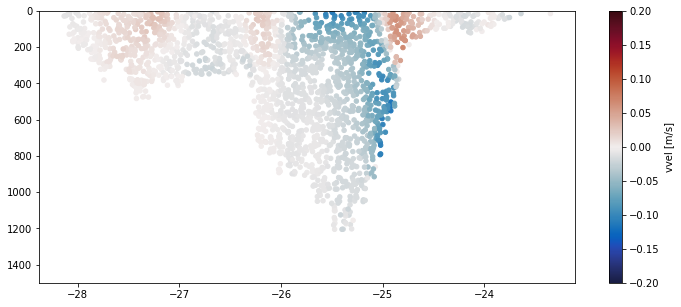

In [12]:
plot_release()

## Calculate some basic parameters from data for later

In [13]:
nParticles = ds.sizes['traj']

In [14]:
#centre time colourscale on release *DOESN'T WORK ON WINDOWS*
tvmin = dsb.time.min(skipna=True).data # oldest time
tvcentre = dsb.time.max(skipna=True).data # oldest time

tvmax = tvcentre + (tvcentre - tvmin)

### Plot trajectories

In [15]:
lon =    ds_full.where(ds_full.time > np.datetime64('2010-06-16')).lon.data.flatten()
lat =    ds_full.where(ds_full.time > np.datetime64('2010-06-16')).lat.data.flatten()
time =   ds_full.where(ds_full.time > np.datetime64('2010-06-16')).time.data.flatten()
 

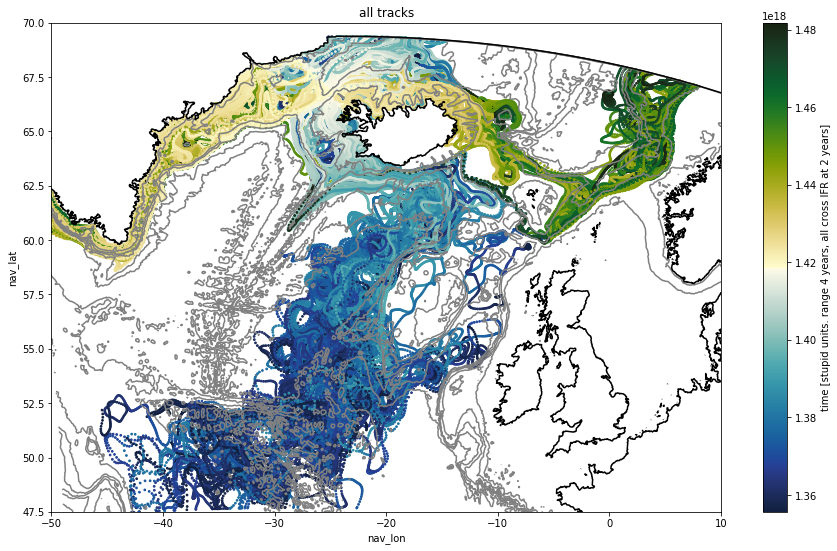

In [16]:
plot_tracks(lon,lat,time,'all tracks')

### Find subsets of trajectories passing through different areas, either upstream or downstream

This just tests whether particles were ever in an area, much easier than testing line crossings.

In [17]:
ds_area = mask_tracks_by_source_sink(ds_full,trelease)

## Plot tracks for some cases

### Tracks coming from the north

In [18]:
lon =   ds_area.where(ds_area.isel(obs=-1).F_North).lon.data.flatten()
lat =   ds_area.where(ds_area.isel(obs=-1).F_North).lat.data.flatten()
time =  ds_area.where(ds_area.isel(obs=-1).F_North).time.data.flatten()

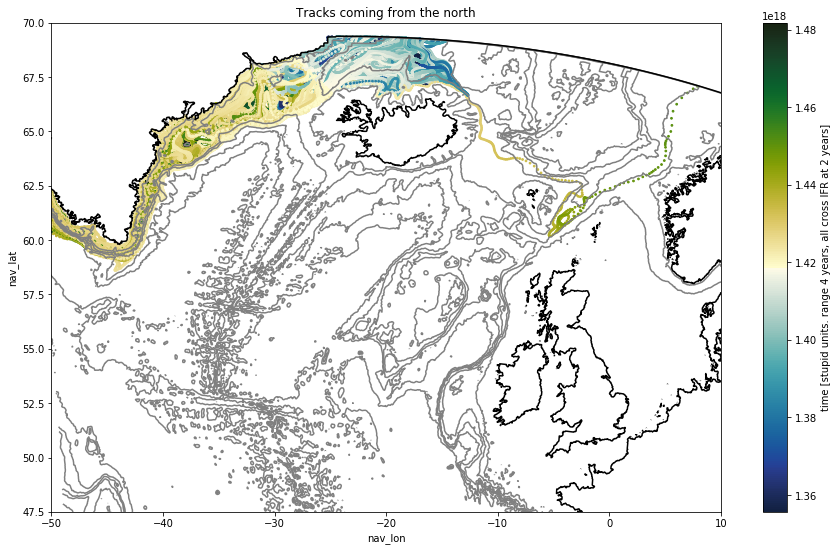

In [19]:
plot_tracks(lon,lat,time,'Tracks coming from the north')

### Tracks coming from south of Iceland and heading east after crossing GI section 

In [20]:
lon =   ds_area.where(ds_area.isel(obs=-1).F_SIceland).where(ds_area.isel(obs=-1).T_East).lon.data.flatten()
lat =   ds_area.where(ds_area.isel(obs=-1).F_SIceland).where(ds_area.isel(obs=-1).T_East).lat.data.flatten()
time =  ds_area.where(ds_area.isel(obs=-1).F_SIceland).where(ds_area.isel(obs=-1).T_East).time.data.flatten()

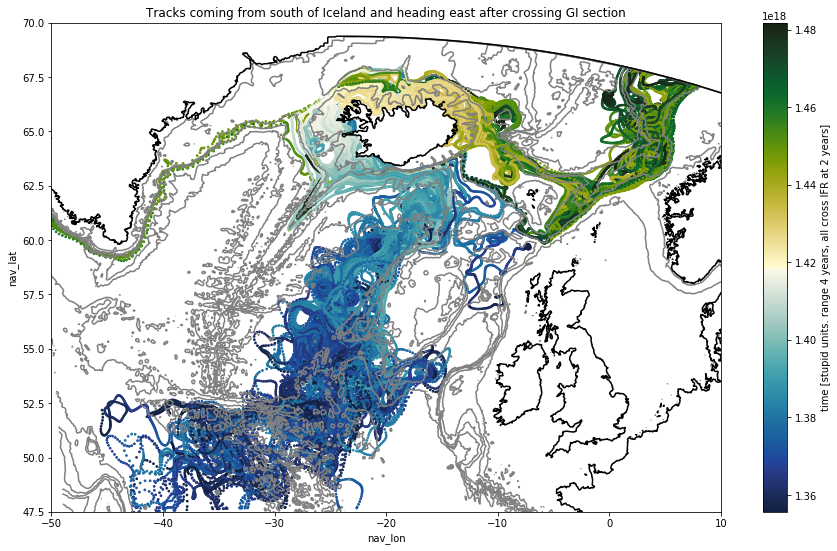

In [21]:
plot_tracks(lon,lat,time,'Tracks coming from south of Iceland and heading east after crossing GI section')

Exclude the few circumnavigating Iceland

In [22]:
lon =   ds_area.where(ds_area.isel(obs=-1).F_SIceland).where(ds_area.isel(obs=-1).T_East).where(ds_area.isel(obs=-1).T_SIceland == False).lon.data.flatten()
lat =   ds_area.where(ds_area.isel(obs=-1).F_SIceland).where(ds_area.isel(obs=-1).T_East).where(ds_area.isel(obs=-1).T_SIceland == False).lat.data.flatten()
time =  ds_area.where(ds_area.isel(obs=-1).F_SIceland).where(ds_area.isel(obs=-1).T_East).where(ds_area.isel(obs=-1).T_SIceland == False).time.data.flatten()

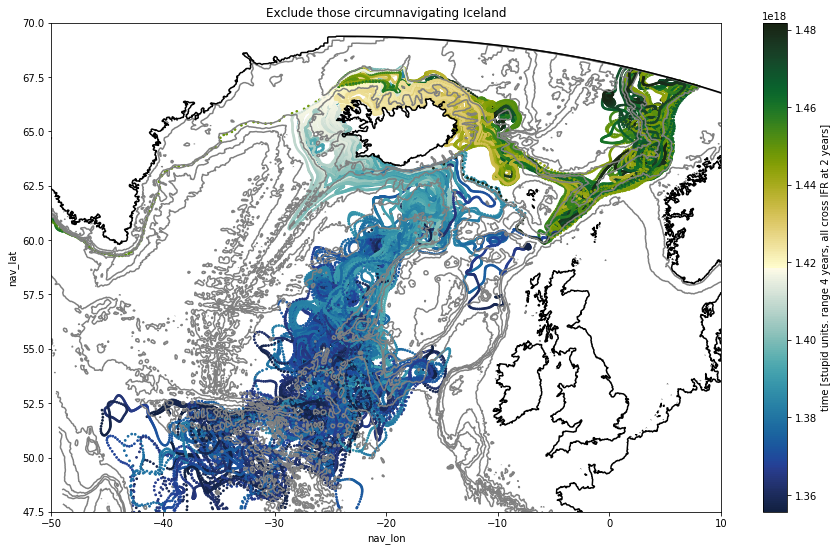

In [23]:
plot_tracks(lon,lat,time,'Exclude those circumnavigating Iceland')

How many get to Norwegian Sea

In [24]:
lon =   ds_area.where(ds_area.isel(obs=-1).F_SIceland).where(ds_area.isel(obs=-1).T_East).where(ds_area.isel(obs=-1).T_SIceland == False).where(ds_area.isel(obs=-1).T_NorwSea).lon.data.flatten()
lat =   ds_area.where(ds_area.isel(obs=-1).F_SIceland).where(ds_area.isel(obs=-1).T_East).where(ds_area.isel(obs=-1).T_SIceland == False).where(ds_area.isel(obs=-1).T_NorwSea).lat.data.flatten()
time =  ds_area.where(ds_area.isel(obs=-1).F_SIceland).where(ds_area.isel(obs=-1).T_East).where(ds_area.isel(obs=-1).T_SIceland == False).where(ds_area.isel(obs=-1).T_NorwSea).time.data.flatten()

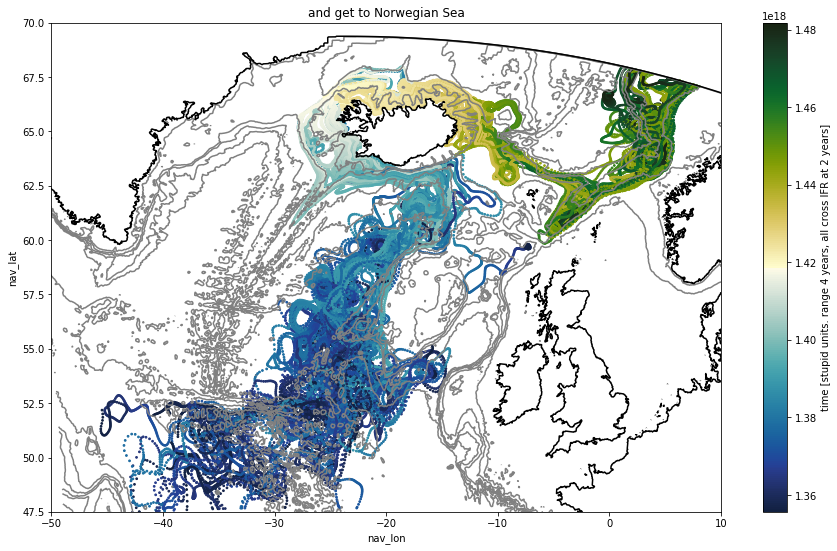

In [25]:
plot_tracks(lon,lat,time,'and get to Norwegian Sea')

### Head south along coast of Greenland

In [26]:
lon =   ds_area.where(ds_area.isel(obs=-1).T_SGreenland).lon.data.flatten()
lat =   ds_area.where(ds_area.isel(obs=-1).T_SGreenland).lat.data.flatten()
time =  ds_area.where(ds_area.isel(obs=-1).T_SGreenland).time.data.flatten()

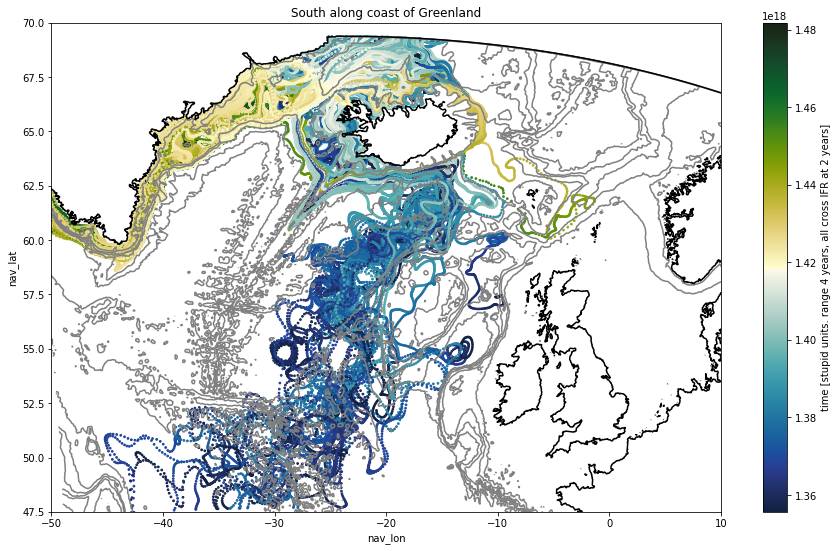

In [27]:
plot_tracks(lon,lat,time,'South along coast of Greenland')

## Plot IFF section coloured by source

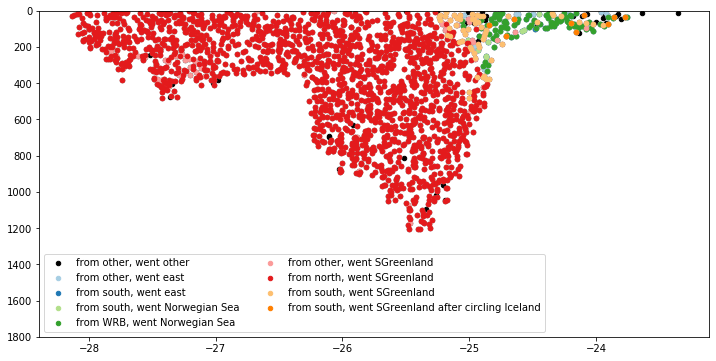

In [28]:
plot_section()

In [29]:
transports()

Total transport through Greenland-Iceland............... -6.515   Sv
...heads south along E Greenland........................ -6.784   Sv
...from south to east...................................  0.277   Sv
......of which to Norwegian Sea.........................  0.230   Sv
.............of which.............from Rockall Trough...  0.013   Sv
.............of which............ from West of Rockall..  0.202   Sv
